In [1]:
setwd("~/Upd-Germline-Genomics")

source("_targets.R")

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
library(GenomicRanges)

Loading required package: stats4



Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expan

In [10]:
tar_load(
  c(
    matches("^chic.experiment.quantify_H3K(4|27|9)_(Germline|Somatic)_peakcalling.broad_chr"),
    chic.tile.diameter_1000_chr,
    chic.tile.diameter_500_score_chr,
    repli.chic.projection.profile_Germline_chr,
    repli.chic.projection.profile_Somatic_chr,
    repli.timing_Germline_chr,
    repli.timing_Somatic_chr
  )
)

In [130]:
library(forcats)
library(pracma)
curvature <- \(x, y) {
  dx <- diff(x)
  dx <- c(head(dx, 1), (dx[-1] + dx[-length(dx)])/2, tail(dx, 1))
  dy <- diff(y)
  dy <- c(head(dy, 1), (dy[-1] + dy[-length(dy)])/2, tail(dy, 1))
  d2x <- diff(diff(x))
  d2y <- diff(diff(y))
  kappa <- 
  kappa <- mapply(
    \(dx, dy, d2x, d2y) norm(cross(c(dx, dy, 0), c(d2x, d2y, 0)), "2") / (dx^2 + dy^2)^1.5,
    dx,
    dy,
    d2x,
    d2y
  )
  kappa
}
trend <- tibble(
  bind_rows(
    list(
      Germline = as.data.frame(repli.chic.projection.profile_Germline_chr),
      Somatic = as.data.frame(repli.chic.projection.profile_Somatic_chr)
    ),
    .id = "celltype"
  ),
  label = cut(repli, c(-Inf, -0.5, 0, 0.5, Inf)) %>%
    `levels<-`(value = c("L", "ML", "EM", "E")) %>%
    fct_relevel(c("E", "EM", "ML", "L")),
) %>%
  subset(sample_size_bp >= 500, select=c(celltype, label, repli, H3K4, H3K27)) %>%
  group_by(celltype, label) %>%
  reframe(
    repli.new = seq(max(repli) + 0.1, min(repli) - 0.1, by = -0.01),
    across(
      c(H3K4, H3K27),
      # \(v) loess(log(v) / log(2) ~ repli) %>% predict()
      \(v) lm(
        log(v) / log(2) ~ poly(repli, 2) # ,
        # weights = sin(pi * (repli - min(repli)) / diff(range(repli)))^2
      ) %>%
        # predict(newdata = list(repli=mean(repli) + c(0, 1e-3))) %>%
        # list(L2FC = ., repli.midpoint = mean(repli) + c(0, 1e-3)) %>%
        # lm(L2FC ~ repli.midpoint, .) %>%
        # predict(newdata = list(repli.midpoint = repli.new))
        predict(newdata = list(repli = repli.new))
    )
  ) %>%
  group_by(celltype, label) %>%
  filter(
    c(
      TRUE,
      sign(diff(H3K4)) == median(sign(diff(H3K4))) & sign(diff(H3K27)) == median(sign(diff(H3K27)))
    ) &
    c(
      sign(diff(H3K4)) == median(sign(diff(H3K4))) & sign(diff(H3K27)) == median(sign(diff(H3K27))),
      TRUE
    )
    # curvature(H3K4, H3K27) <= 1
  ) %>%
  reframe(
    repli.new = c(repli.new, NA),
    across(
      c(H3K4, H3K27),
      \(v) c(
        v,
        tail(v, 1) + 1e-3 * (tail(v, 1) - v[length(v)/2]) / (length(v)/2)
      )
    )
  ) %>%
  print()

# A tibble: 343 × 5
   celltype label repli.new  H3K4 H3K27
   <chr>    <fct>     <dbl> <dbl> <dbl>
 1 Germline E         1.02  0.408 0.369
 2 Germline E         1.01  0.398 0.351
 3 Germline E         0.998 0.389 0.333
 4 Germline E         0.988 0.379 0.316
 5 Germline E         0.978 0.370 0.299
 6 Germline E         0.968 0.361 0.283
 7 Germline E         0.958 0.353 0.267
 8 Germline E         0.948 0.344 0.252
 9 Germline E         0.938 0.336 0.237
10 Germline E         0.928 0.328 0.223
# ℹ 333 more rows


In [156]:
trend_fit <- tibble(
  bind_rows(
    list(
      Germline = as.data.frame(repli.chic.projection.profile_Germline_chr),
      Somatic = as.data.frame(repli.chic.projection.profile_Somatic_chr)
    ),
    .id = "celltype"
  ),
  label = cut(repli, c(-Inf, -0.5, 0, 0.5, Inf)) %>%
    `levels<-`(value = c("L", "ML", "EM", "E")) %>%
    fct_relevel(c("E", "EM", "ML", "L")),
) %>%
  subset(sample_size_bp >= 500, select=c(celltype, label, repli, H3K4, H3K27, sample_size_bp)) %>%
  group_by(celltype, label) %>%
  summarise(
    lm = lm(
      log(H3K27) ~ log(H3K4),
      weights = sample_size_bp
    ) %>%
      list(),
    R = coef(lm[[1]])[2] / (
      sqrt(weighted.mean(log(H3K27)^2 - weighted.mean(log(H3K27), sample_size_bp)^2, sample_size_bp)) /
        sqrt(weighted.mean(log(H3K4)^2 - weighted.mean(log(H3K4), sample_size_bp)^2, sample_size_bp))
    ),
    R2 = R^2
  ) %>%
  print()

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


# A tibble: 8 × 5
# Groups:   celltype [2]
  celltype label lm           R      R2
  <chr>    <fct> <list>   <dbl>   <dbl>
1 Germline E     <lm>    0.743  0.553  
2 Germline EM    <lm>   -0.222  0.0494 
3 Germline ML    <lm>    0.721  0.520  
4 Germline L     <lm>    0.628  0.394  
5 Somatic  E     <lm>    0.701  0.492  
6 Somatic  EM    <lm>    0.901  0.812  
7 Somatic  ML    <lm>    0.651  0.424  
8 Somatic  L     <lm>   -0.0336 0.00113


In [148]:
coef(trend_fit$R[[1]])

(Intercept)        H3K4 
  0.4866085   0.4724315

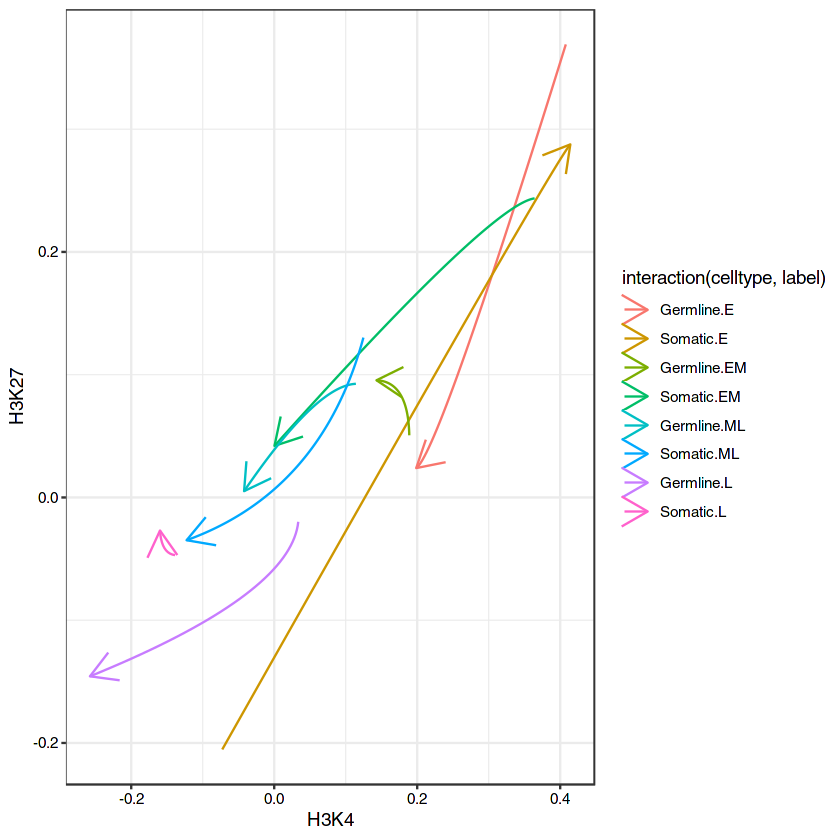

In [123]:
library(ggplot2)
ggplot(
  trend,
  aes(H3K4, H3K27, color = interaction(celltype, label))
) +
  geom_path(arrow = arrow())

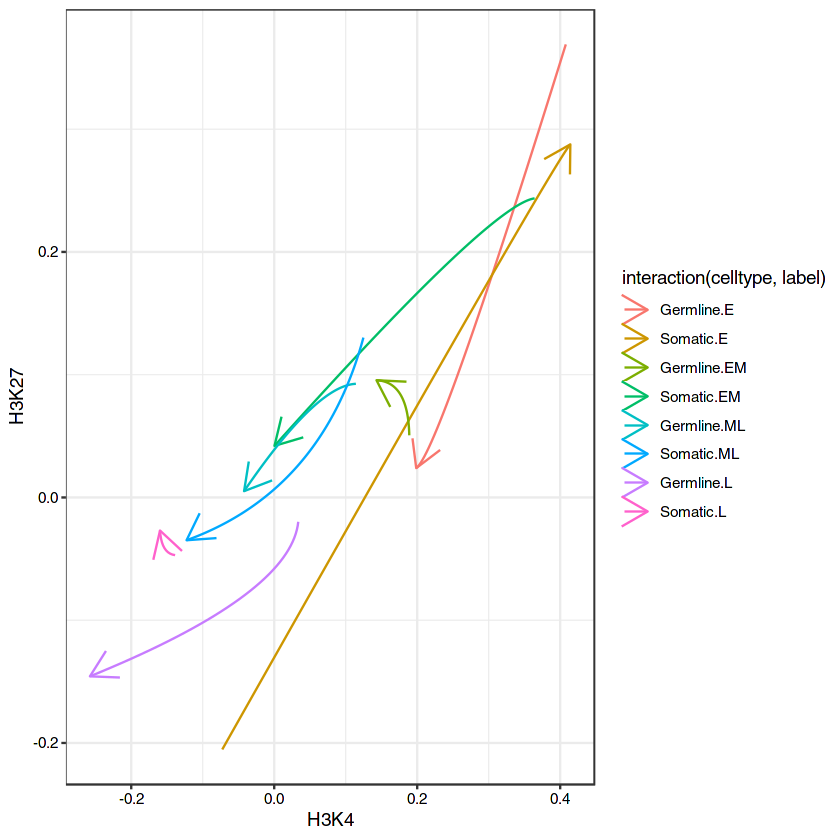

In [131]:
library(ggplot2)
ggplot(
  trend,
  aes(H3K4, H3K27, color = interaction(celltype, label))
) +
  geom_path(arrow = arrow())

## Whether to cut into equal amounts of chromatin, or according to the cuts of the timing estimator range?

We want to create levels of replication timing that reveal something useful. A common regime of replication timing definitely exists between germline and somatic, so strive to achieve a reasonable germline-somatic correlation in the cuts that we are making.

However, the impact is only a few percent of R^2. Therefore, we will say that we did successfully cut the chromatin into 4 levels according to the range of the track value, although the Germline L fraction (from track value) is markedly depleted.

In [4]:
Y1 <- reframe(
  tibble(
    Germline = repli.timing_Germline_chr$score %>% head(sum(seqnames(chic.tile.diameter_1000_chr) %in% names(chr.lengths))),
    Somatic = repli.timing_Somatic_chr$score %>% head(sum(seqnames(chic.tile.diameter_1000_chr) %in% names(chr.lengths))),
  ),
  across(
    everything(),
    \(v) v %>% rank() %>% cut(seq(0, length(.), length.out = 5)) %>% as.numeric()
  )
) %>%
  print(n=5)
Y2 <- reframe(
  tibble(
    Germline = repli.timing_Germline_chr$score %>% head(sum(seqnames(chic.tile.diameter_1000_chr) %in% names(chr.lengths))),
    Somatic = repli.timing_Somatic_chr$score %>% head(sum(seqnames(chic.tile.diameter_1000_chr) %in% names(chr.lengths))),
  ),
  across(
    everything(),
    \(v) v %>% cut(c(-Inf, -0.5, 0, 0.5, Inf)) %>% as.numeric()
  )
) %>%
  print(n=5)
print(cor(Y1)^2)
print(cor(Y2)^2)

# A tibble: 137,552 × 2
  Germline Somatic
     <dbl>   <dbl>
1        4       4
2        4       4
3        4       4
4        4       4
5        4       3
# ℹ 137,547 more rows
# A tibble: 137,552 × 2
  Germline Somatic
     <dbl>   <dbl>
1        4       4
2        4       4
3        4       4
4        4       4
5        4       3
# ℹ 137,547 more rows
          Germline   Somatic
Germline 1.0000000 0.3386219
Somatic  0.3386219 1.0000000
          Germline   Somatic
Germline 1.0000000 0.3238118
Somatic  0.3238118 1.0000000


In [5]:
overlaps <- cross_join(
  tibble(celltype = c("Germline", "Somatic")),
  tibble(label = c("E", "EM", "ML", "L") %>% factor(., .))
) %>%
  group_by(celltype) %>%
  mutate(
    i = split(
      as.list(
        findOverlaps(chic.tile.diameter_1000_chr, chic.tile.diameter_500_score_chr)
      ),
      cut(
        get(str_glue("repli.timing_{celltype[1]}_chr"))$score,
        c(-Inf, -0.5, 0, 0.5, Inf)
      ) %>%
        factor(c("(0.5, Inf]", "(0,0.5]", "(-0.5,0]", "(-Inf,-0.5]"))
    ) %>%
      sapply(\(lst) unique(do.call(c, lst)))
  ) %>%
  print()

# A tibble: 8 × 3
# Groups:   celltype [2]
  celltype label i              
  <chr>    <fct> <named list>   
1 Germline E     <int [393,956]>
2 Germline EM    <int [385,440]>
3 Germline ML    <int [422,895]>
4 Germline L     <int [175,825]>
5 Somatic  E     <int [302,949]>
6 Somatic  EM    <int [449,353]>
7 Somatic  ML    <int [301,666]>
8 Somatic  L     <int [324,148]>


In [6]:
# 500 bp window, 100 bp step: Grab the windows that are centered e.g. 1-500, 501-1000.
overlaps <- overlaps %>%
  mutate(i = i %>% sapply(\(v) subset(v, v %% 5 == 3 & v <= sum(seqnames(chic.tile.diameter_500_score_chr) %in% names(chr.lengths))))) %>%
  print()

# A tibble: 8 × 3
# Groups:   celltype [2]
  celltype label i             
  <chr>    <fct> <named list>  
1 Germline E     <int [78,707]>
2 Germline EM    <int [77,004]>
3 Germline ML    <int [84,460]>
4 Germline L     <int [34,926]>
5 Somatic  E     <int [60,589]>
6 Somatic  EM    <int [89,800]>
7 Somatic  ML    <int [59,990]>
8 Somatic  L     <int [64,718]>


In [7]:
overlaps_uniform <- cross_join(
  tibble(celltype = c("Germline", "Somatic")),
  tibble(label = c("E", "EM", "ML", "L") %>% factor(., .))
) %>%
  group_by(celltype) %>%
  mutate(
    i = order(
      get(str_glue("repli.timing_{celltype[1]}_chr"))$score %>%
        head(sum(seqnames(chic.tile.diameter_1000_chr) %in% names(chr.lengths)))
    ) %>%
      split(
        cut(seq_along(.), seq(0, length(.), length.out = 5))
      ) %>%
      sapply(\(diameter_1000_inds) chic.tile.diameter_1000_chr[diameter_1000_inds] %>%
        findOverlaps(chic.tile.diameter_500_score_chr) %>%
        to() %>%
        subset(. %% 5 == 3) %>%
        unique()
      )
  ) %>%
  print()

# A tibble: 8 × 3
# Groups:   celltype [2]
  celltype label i             
  <chr>    <fct> <named list>  
1 Germline E     <int [68,772]>
2 Germline EM    <int [68,776]>
3 Germline ML    <int [68,776]>
4 Germline L     <int [68,773]>
5 Somatic  E     <int [68,775]>
6 Somatic  EM    <int [68,771]>
7 Somatic  ML    <int [68,776]>
8 Somatic  L     <int [68,775]>


In [8]:
chromatin <- overlaps %>%
  group_by(celltype, label) %>%
  reframe(
    tibble(
      H3 = get(str_glue("chic.experiment.quantify_H3K27_{celltype[1]}_peakcalling.broad_chr"))$score.molH3[i[[1]]],
      H3K4 = get(str_glue("chic.experiment.quantify_H3K4_{celltype[1]}_peakcalling.broad_chr"))$L2FC[i[[1]]],
      H3K27 = get(str_glue("chic.experiment.quantify_H3K27_{celltype[1]}_peakcalling.broad_chr"))$L2FC[i[[1]]],
    )
  ) %>%
  subset(between(abs(H3K4), 1e-6, 9.9) & between(abs(H3K27), 1e-6, 9.9)) %>%
  print()

# A tibble: 501,201 × 5
   celltype label    H3    H3K4   H3K27
   <chr>    <fct> <dbl>   <dbl>   <dbl>
 1 Germline E     0.456 -0.0578 -0.196 
 2 Germline E     1.20  -0.286   0.339 
 3 Germline E     1.31  -0.869  -0.995 
 4 Germline E     1.34  -0.757  -0.220 
 5 Germline E     0.841 -1.56   -2.52  
 6 Germline E     1.36   0.826  -0.392 
 7 Germline E     1.45   0.427   0.0677
 8 Germline E     1.29   0.0333  0.316 
 9 Germline E     1.30  -0.218  -0.267 
10 Germline E     1.06  -1.18   -3.17  
# ℹ 501,191 more rows


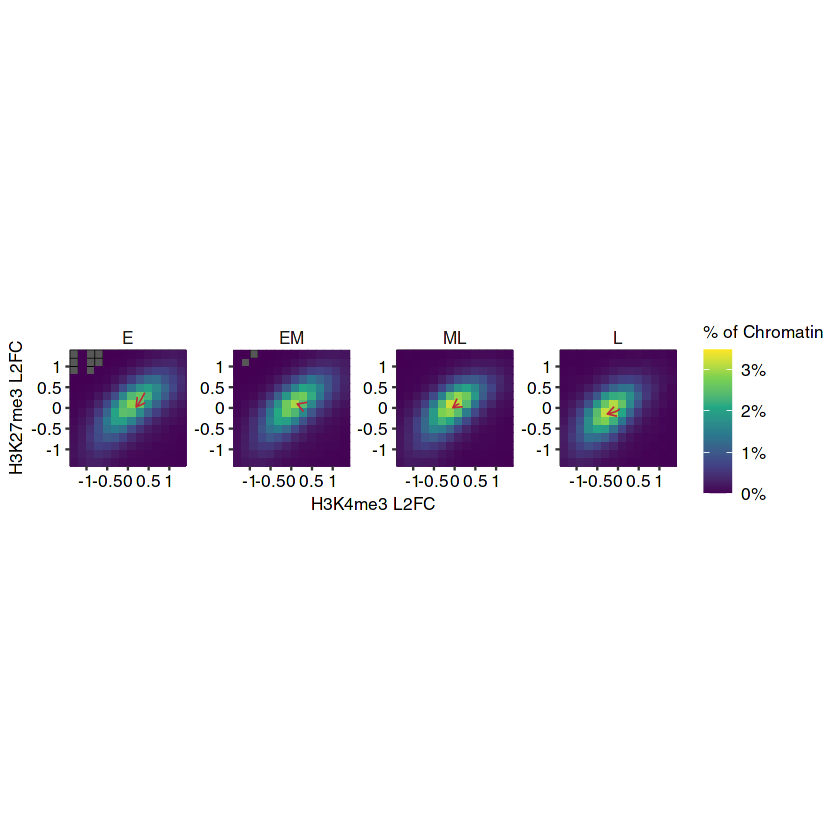

In [139]:
library(ggplot2)
library(scales)
plot_limits <- 7.4
annotate_polygon <- 1.38
p <- ggplot(
  chromatin,
  aes(H3K4, H3K27, fill = after_stat(density))
) +
  facet_wrap(vars(label), scales = "free", nrow = 1) +
  geom_bin2d(binwidth = 0.2) +
  # geom_smooth(aes(fill=NULL), method = "lm") +
  geom_path(
    aes(fill = NULL),
    data = \(chromatin) trend %>%
      subset(celltype == chromatin$celltype[1]),
    color = "#c0253a",
    arrow = arrow(length = unit(6, "pt")),
    linewidth = 1 * 25.4 / 72,
  ) +
  scale_fill_viridis_c(
    "% of Chromatin",
    limits = c(0, 0.035),
    labels = percent
  ) +
  scale_x_continuous(
    limits = c(-plot_limits, plot_limits), expand=c(0, 0),
    minor_breaks = seq(-1.4, 1.4, by=0.2),
    labels = as.numeric
  ) +
  scale_y_continuous(
    limits = c(-plot_limits, plot_limits), expand=c(0, 0),
    minor_breaks = seq(-1.4, 1.4, by=0.2),
    labels = as.numeric
  ) +
  coord_cartesian(c(-1.4,1.4), c(-1.4,1.4)) +
  labs(x = "H3K4me3 L2FC", y = "H3K27me3 L2FC") +
  theme(
    aspect.ratio = 1,
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 10),
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 10),
    panel.background = element_rect(fill = "#575757"),
    panel.grid = element_line(color = "black", linewidth = 0.5 * 25.4 / 72),
    panel.grid.minor = element_line(color = "black", linewidth = 0.5 * 25.4 / 72),
    panel.border = element_blank(),
    plot.title = element_text(size = 10),
    strip.background = element_blank(),
    strip.text = element_text(size = 10, margin = margin(2, 2, 2, 2)),
  )
p

In [41]:
print(subset(chromatin, label == "E"))

# A tibble: 136,242 × 5
   celltype label    H3    H3K4   H3K27
   <chr>    <fct> <dbl>   <dbl>   <dbl>
 1 Germline E     0.456 -0.0578 -0.196 
 2 Germline E     1.20  -0.286   0.339 
 3 Germline E     1.31  -0.869  -0.995 
 4 Germline E     1.34  -0.757  -0.220 
 5 Germline E     0.841 -1.56   -2.52  
 6 Germline E     1.36   0.826  -0.392 
 7 Germline E     1.45   0.427   0.0677
 8 Germline E     1.29   0.0333  0.316 
 9 Germline E     1.30  -0.218  -0.267 
10 Germline E     1.06  -1.18   -3.17  
# ℹ 136,232 more rows


In [42]:
print(subset(chromatin, label == "EM"))

# A tibble: 159,054 × 5
   celltype label      H3   H3K4   H3K27
   <chr>    <fct>   <dbl>  <dbl>   <dbl>
 1 Germline EM    1.36     0.573  0.255 
 2 Germline EM    0.995    0.434 -0.326 
 3 Germline EM    1.25     0.127 -0.198 
 4 Germline EM    1.26     0.158 -0.100 
 5 Germline EM    1.08    -0.560  0.200 
 6 Germline EM    0.0718   0.964 -0.222 
 7 Germline EM    0.00769  1.83   2.11  
 8 Germline EM    1.41    -1.39  -1.12  
 9 Germline EM    1.59    -0.139 -0.466 
10 Germline EM    2.22     0.275 -0.0369
# ℹ 159,044 more rows


In [44]:
correlations <- chromatin %>%
  group_by(celltype, label) %>%
  reframe(
    across(
      everything(),
      list(
        z = \(v) scale(v)[, 1],
        var = var
      )
    )
  ) %>%
  print() %>%
  group_by(label) %>%
  summarise(
    R_Germline = cor(H3K4_z[celltype == "Germline"], H3K27_z[celltype == "Germline"]),
    R_Somatic = cor(H3K4_z[celltype == "Somatic"], H3K27_z[celltype == "Somatic"]),
    Var_Germline_H3K4 = H3K4_var[match("Germline", celltype)],
    Var_Germline_H3K27 = H3K27_var[match("Germline", celltype)],
    Var_Somatic_H3K4 = H3K4_var[match("Somatic", celltype)],
    Var_Somatic_H3K27 = H3K27_var[match("Somatic", celltype)],
    model = lm(
        H3K27_z ~ H3K4_z * celltype
    ) %>%
      list()
  ) %>%
  print(width = 180)

# A tibble: 501,201 × 8
   celltype label     H3_z H3_var  H3K4_z H3K4_var H3K27_z H3K27_var
   <chr>    <fct>    <dbl>  <dbl>   <dbl>    <dbl>   <dbl>     <dbl>
 1 Germline E     -1.71     0.125 -0.180     0.440  -0.196     0.410
 2 Germline E      0.385    0.125 -0.525     0.440   0.640     0.410
 3 Germline E      0.700    0.125 -1.40      0.440  -1.44      0.410
 4 Germline E      0.780    0.125 -1.23      0.440  -0.232     0.410
 5 Germline E     -0.628    0.125 -2.45      0.440  -3.82      0.410
 6 Germline E      0.825    0.125  1.15      0.440  -0.500     0.410
 7 Germline E      1.08     0.125  0.550     0.440   0.216     0.410
 8 Germline E      0.644    0.125 -0.0431    0.440   0.604     0.410
 9 Germline E      0.680    0.125 -0.421     0.440  -0.305     0.410
10 Germline E     -0.00780  0.125 -1.87      0.440  -4.84      0.410
# ℹ 501,191 more rows
# A tibble: 4 × 8
  label R_Germline R_Somatic Var_Germline_H3K4 Var_Germline_H3K27
  <fct>      <dbl>     <dbl>             <

In [45]:
summary(correlations$model[[1]])


Call:
lm(formula = H3K27_z ~ H3K4_z * celltype)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4009 -0.3803  0.0617  0.4664  5.8550 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             2.071e-17  2.700e-03   0.000        1    
H3K4_z                  6.727e-01  2.700e-03 249.161  < 2e-16 ***
celltypeSomatic        -9.488e-17  4.082e-03   0.000        1    
H3K4_z:celltypeSomatic -1.907e-02  4.082e-03  -4.672 2.98e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7474 on 136238 degrees of freedom
Multiple R-squared:  0.4414,	Adjusted R-squared:  0.4414 
F-statistic: 3.589e+04 on 3 and 136238 DF,  p-value: < 2.2e-16


In [161]:
print(trend_fit)

# A tibble: 8 × 5
# Groups:   celltype [2]
  celltype label lm           R      R2
  <chr>    <fct> <list>   <dbl>   <dbl>
1 Germline E     <lm>    0.743  0.553  
2 Germline EM    <lm>   -0.222  0.0494 
3 Germline ML    <lm>    0.721  0.520  
4 Germline L     <lm>    0.628  0.394  
5 Somatic  E     <lm>    0.701  0.492  
6 Somatic  EM    <lm>    0.901  0.812  
7 Somatic  ML    <lm>    0.651  0.424  
8 Somatic  L     <lm>   -0.0336 0.00113


In [182]:
subset(trend, celltype == "Somatic" & label == "E") %>% reframe(across(c(H3K4, H3K27), diff)) %>%
  print() %>%
  reframe(across(c(H3K4, H3K27), \(v) c(quantile(v, c(0, 0.25)), mean(v), quantile(v, c(0.5, 0.75, 1))))) %>%
  with(H3K27 / H3K4)

# A tibble: 33 × 2
     H3K4  H3K27
    <dbl>  <dbl>
 1 0.0285 0.0294
 2 0.0276 0.0285
 3 0.0268 0.0276
 4 0.0259 0.0267
 5 0.0251 0.0258
 6 0.0242 0.0249
 7 0.0234 0.0240
 8 0.0225 0.0231
 9 0.0216 0.0222
10 0.0208 0.0213
# ℹ 23 more rows


0%       25%                 50%       75%      100% 
0.9824254 0.9747465 1.0124566 1.0112669 1.0246572 1.0316064

In [184]:
trend %>% group_by(celltype, label) %>% summarise(mean(diff(H3K27) / diff(H3K4)), mean(diff(H3K27)) / mean(diff(H3K4)))

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


celltype,label,mean(diff(H3K27)/diff(H3K4)),mean(diff(H3K27))/mean(diff(H3K4))
<chr>,<fct>,<dbl>,<dbl>
Germline,E,1.5184675,1.6496345
Germline,EM,-2.4788194,-0.9781834
Germline,ML,0.5238163,0.5591630
Germline,L,0.7276660,0.4320114
Somatic,E,0.9863682,1.0124566
Somatic,EM,0.5075470,0.5542012
Somatic,ML,0.8097812,0.6674274
Somatic,L,-1.7157695,-0.9485688


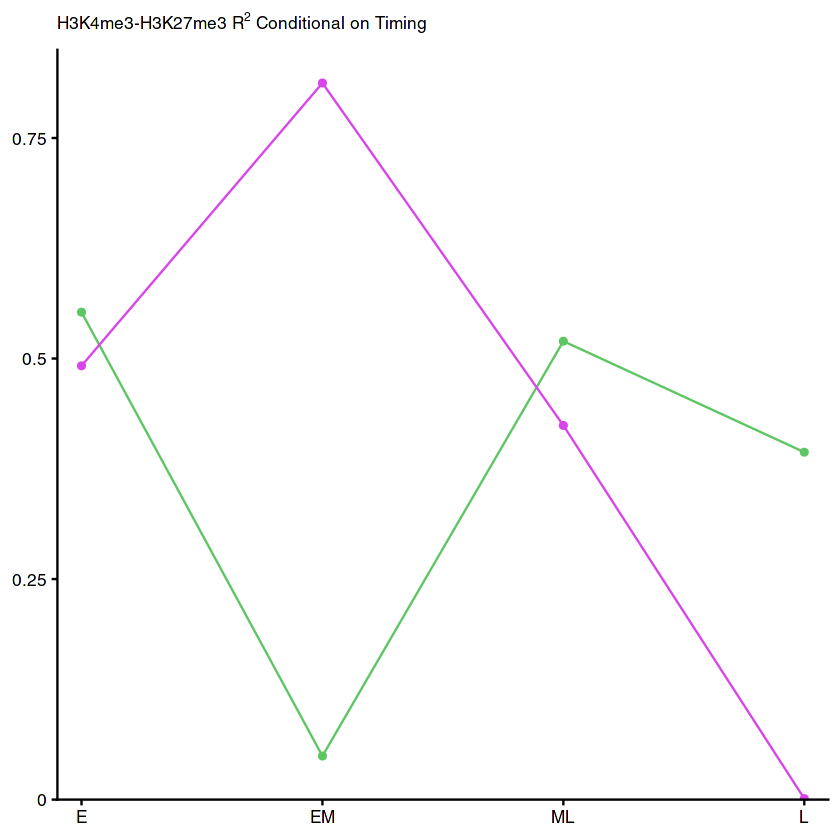

In [168]:
library(cowplot)
corrplot <- ggplot(trend_fit, aes(label, R2)) +
  geom_line(aes(group = 1),data = \(data) data %>% subset(celltype == "Germline"), color = chic_line_track_colors$germline) +
  geom_point(data = \(data) data %>% subset(celltype == "Germline"), color = chic_line_track_colors$germline) +
  geom_line(aes(group = 1),data = \(data) data %>% subset(celltype == "Somatic"), color = chic_line_track_colors$somatic) +
  geom_point(data = \(data) data %>% subset(celltype == "Somatic"), color = chic_line_track_colors$somatic) +
  scale_y_continuous(breaks = c(0, 0.25, 0.5, 0.75), labels = as.numeric) +
  coord_cartesian(c(0.9, 4.1), c(0, 0.85), ex=F) +
  labs(title=bquote("H3K4me3-H3K27me3 R"^2*" Conditional on Timing"), x = NULL, y = NULL) +
  theme_cowplot() +
  theme(
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 10)
  )
corrplot

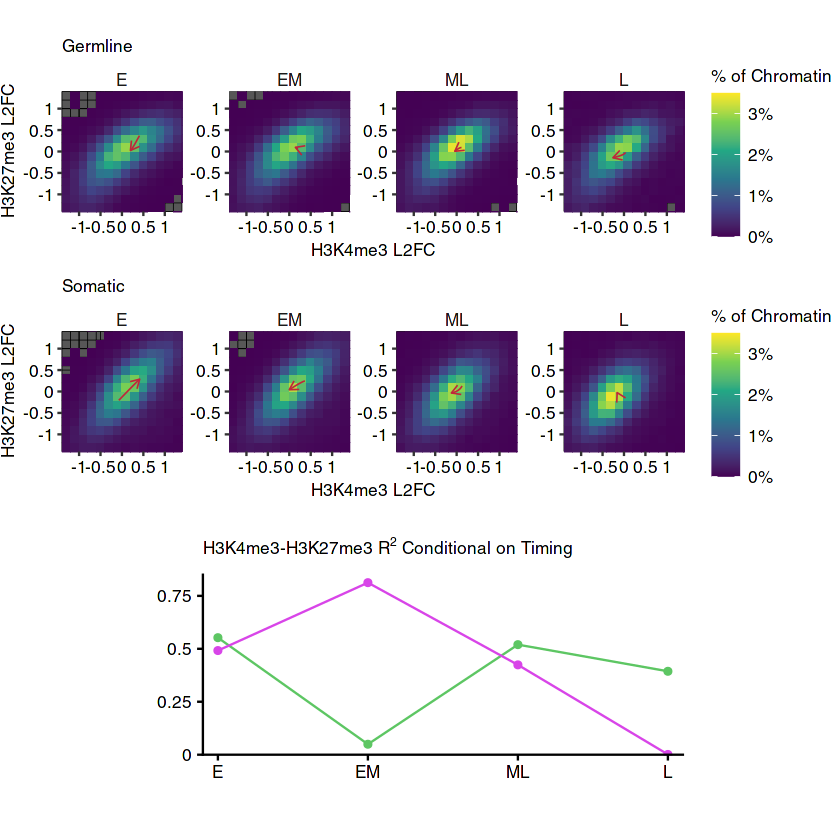

In [169]:
library(egg)
library(grid)
library(gtable)
report <- gtable(
  unit(1, "null"),
  unit(c(2, 2, 2.5), "in")
) %>%
  gtable_add_grob(
    list(
      set_panel_size(
        p %>%
          `$<-`("data", value = .$data %>% subset(celltype == "Germline")) %>%
          `+`(labs(title = "Germline")),
        w = unit(1, "in"),
        h = unit(1, "in")
      ),
      set_panel_size(
        p %>%
          `$<-`("data", value = .$data %>% subset(celltype == "Somatic")) %>%
          `+`(labs(title = "Somatic")),
        w = unit(1, "in"),
        h = unit(1, "in")
      ),
      set_panel_size(
        corrplot,
        w = unit(4, "in"),
        h = unit(1.5, "in")
      )
    ),
    t = 1:3,
    l = 1
  )
grid.draw(report)

In [170]:
library(Cairo)
CairoPDF("illustrations/Histone-Corr-Timing-Group-L2FC-Bar-Data.pdf", w = 11, h = 8.5)
grid.draw(report)
dev.off()

png 
  2